<a href="https://colab.research.google.com/github/AlisaUrikh/ml_repo/blob/main/%D0%A3%D1%80%D0%B8%D1%85_eda_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Установка и импорт

В этом задании вам предстоит выполнить полный EDA анализ
и ответить на вопросы по результатам анализа.

Для выполнения задания:
1. Изучите данные и выполните весь пайплайн EDA
2. Ответьте на вопросы в конце файла
3. Заполните ответы в словаре answers

In [236]:
# Импорт библиотек
import numpy as np
import pandas as pd
import warnings
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import skew

# 2. Загрузка данных

Данные о страховых случаях

Описание признаков:
- age: возраст клиента
- bmi: индекс массы тела
- children: количество детей/иждивенцев
- charges: стоимость страховки
- smoker: курит ли клиент (yes/no)
- region: регион проживания (southwest, southeast, northwest, northeast)
- insurance_claim: была ли подана страховка (0 - нет, 1 - да)

In [177]:
np.random.seed(2024)
n_samples = 1000

# Создаем DataFrame
df_insurance = pd.DataFrame({
    'age': np.random.normal(40, 15, n_samples).clip(18, 80).astype(int),
    'bmi': np.random.normal(28, 6, n_samples).clip(15, 50),
    'children': np.random.poisson(1.5, n_samples).clip(0, 5),
    'charges': np.random.exponential(15000, n_samples) + 1000,
    'smoker': np.random.choice(['yes', 'no'], n_samples, p=[0.2, 0.8]),
    'region': np.random.choice(['southwest', 'southeast', 'northwest', 'northeast'],
                               n_samples, p=[0.25, 0.3, 0.25, 0.2]),
    'insurance_claim': np.random.binomial(1, 0.3, n_samples)
})

# Добавляем реалистичные зависимости
df_insurance.loc[df_insurance['smoker'] == 'yes', 'charges'] *= 2.5
df_insurance.loc[df_insurance['age'] > 60, 'charges'] *= 1.3
df_insurance.loc[df_insurance['bmi'] > 35, 'charges'] *= 1.2

# Добавляем пропуски (реалистичный паттерн)
# У курильщиков реже заполнен BMI
smoker_mask = df_insurance['smoker'] == 'yes'
df_insurance.loc[smoker_mask & (np.random.rand(n_samples) < 0.15), 'bmi'] = np.nan

# У пожилых реже заполнены дети
age_mask = df_insurance['age'] > 65
df_insurance.loc[age_mask & (np.random.rand(n_samples) < 0.1), 'children'] = np.nan

# В северо-восточном регионе пропуски в charges
region_mask = df_insurance['region'] == 'northeast'
df_insurance.loc[region_mask & (np.random.rand(n_samples) < 0.08), 'charges'] = np.nan

# Добавляем выбросы
# Выбросы в charges
outlier_indices = np.random.choice(n_samples, 15, replace=False)
df_insurance.loc[outlier_indices, 'charges'] *= 4

# Выбросы в bmi
outlier_indices_bmi = np.random.choice(n_samples, 10, replace=False)
df_insurance.loc[outlier_indices_bmi, 'bmi'] = df_insurance.loc[outlier_indices_bmi, 'bmi'] * 1.8

Задание 1: вывести на экран "шапку", размер датафрейма, количество признаков, представленные типы данных и статистику числовых признаков

In [ ]:
# Ваш код здесь

Размер датасета: (1000, 7)
Количество признаков: 7

Первый взгляд на данные:


,age,bmi,children,charges,smoker,region,insurance_claim
0,65,36.349066,0.0,NaN,no,northeast,1
1,51,28.934381,1.0,2583.734319,no,southeast,0
2,36,25.402012,3.0,53941.526800,yes,northeast,0
3,37,23.954296,2.0,5739.464506,no,northeast,1
4,53,29.530733,1.0,15400.573233,no,southeast,0
5,57,27.974254,0.0,22175.648880,yes,southeast,0
6,18,28.641012,0.0,9480.234180,no,southwest,0
7,20,31.548388,0.0,46261.975814,no,northwest,0
8,46,33.195100,1.0,7975.315155,no,southwest,1
9,41,31.017926,0.0,42029.973864,no,southwest,1



Информация о типах данных:
age                  int64
bmi                float64
children           float64
charges            float64
smoker              object
region              object
insurance_claim      int64
dtype: object

Базовая статистика числовых признаков:
           age     bmi  children    charges  insurance_claim
count  1000.00  970.00    995.00     983.00          1000.00
mean     40.32   27.99      1.49   21395.19             0.31
std      14.18    6.43      1.19   23405.23             0.46
min      18.00   15.00      0.00    1010.62             0.00
25%      30.00   23.57      1.00    6317.17             0.00
50%      40.00   27.99      1.00   14823.22             0.00
75%      50.00   32.17      2.00   27662.99             1.00
max      80.00   63.65      5.00  259808.00             1.00


In [178]:
print(f"Шапка датафрейма: \n{df_insurance.head(11)}\n")

print(f"Размер датафрейма: {df_insurance.shape} \nКоличество признаков: {df_insurance.shape[1]}\n")

print(f"Информация о типах данных: \n{df_insurance.dtypes.to_string()}\n")

print(f"Базовая статистика числовых признаков: \n{df_insurance.describe()}")

Шапка датафрейма: 
    age        bmi  children       charges smoker     region  insurance_claim
0    65  36.349066       0.0           NaN     no  northeast                1
1    51  28.934381       1.0   2583.734319     no  southeast                0
2    36  25.402012       3.0  53941.526800    yes  northeast                0
3    37  23.954296       2.0   5739.464506     no  northeast                1
4    53  29.530733       1.0  15400.573233     no  southeast                0
5    57  27.974254       0.0  22175.648880    yes  southeast                0
6    18  28.641012       0.0   9480.234180     no  southwest                0
7    20  31.548388       0.0  46261.975814     no  northwest                0
8    46  33.195100       1.0   7975.315155     no  southwest                1
9    41  31.017926       0.0  42029.973864     no  southwest                1
10   55  34.732603       2.0   1955.088841     no  northeast                0

Размер датафрейма: (1000, 7) 
Количество при

# 3. Анализ пропусков с использованием msno, dropna, isnull

Задание 2: провести анализ по плану

In [77]:
# 1. Используем isnull для подсчета пропусков

# 2. Визуализация пропусков с помощью msno
#       - Матрица пропусков
#       - Bar chart пропусков

# 3. Применение dropna для анализа
#       - Разные стратегии удаления пропусков: все строки, все столбцы, с порогом

Количество пропусков по признакам:
age: нет пропусков
bmi: 30 пропусков (3.0%)
children: 5 пропусков (0.5%)
charges: 17 пропусков (1.7%)
smoker: нет пропусков
region: нет пропусков
insurance_claim: нет пропусков

Анализ с использованием .dropna():
Исходный размер: (1000, 7)
После .dropna(): (948, 7)
После .dropna(axis=1): (1000, 4)
После .dropna(thresh=6): (1000, 7)


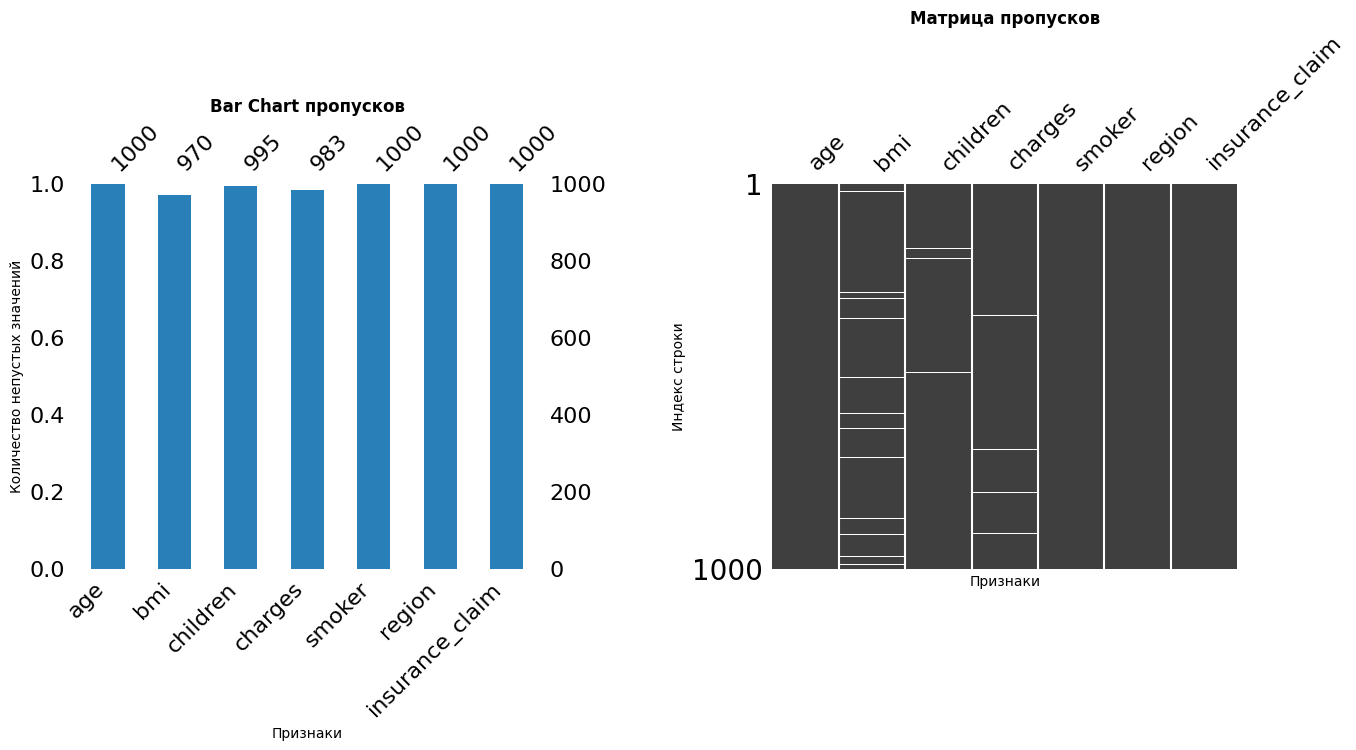

In [179]:
# 1. Используем isnull для подсчета пропусков
missing_counts = df_insurance.isnull().sum()

print("Количество пропусков по признакам:")
for col, count in missing_counts.items():
    if count == 0:
        print(f"{col}: нет пропусков")
    else:
        print(f"{col}: {count} пропусков ({count/10}%)")

# 2. Визуализация пропусков с помощью msno
#       - Матрица пропусков
#       - Bar chart пропусков
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.5)

ax1 = fig.add_subplot(gs[0, 0])
msno.bar(df_insurance, ax=ax1, color='#2980b9')
ax1.set_title('Bar Chart пропусков', fontsize=12, fontweight='bold')
ax1.set_xlabel('Признаки', fontsize=10)
ax1.set_ylabel('Количество непустых значений', fontsize=10)

ax2 = fig.add_subplot(gs[0, 1])
msno.matrix(df_insurance, ax=ax2, sparkline=False)
ax2.set_title('Матрица пропусков', fontsize=12, fontweight='bold')
ax2.set_xlabel('Признаки', fontsize=10)
ax2.set_ylabel('Индекс строки', fontsize=10)


# 3. Применение dropna для анализа
#       - Разные стратегии удаления пропусков: все строки, все столбцы, с порогом
print("\nАнализ с использованием .dropna():")
print(f"Исходный размер: {df_insurance.shape}")
print(f"После .dropna(): {df_insurance.dropna().shape}")
print(f"После .dropna(axis=1): {df_insurance.dropna(axis=1).shape}")
print(f"После .dropna(thresh=6): {df_insurance.dropna(thresh=6).shape}")

# 4. Визуализация с boxplot и iqr

Задание 3: визуализируйте числовые признаки с boxplot и посчитывайте выбросы с iqr

Числовые признаки: ['age', 'bmi', 'children', 'charges', 'insurance_claim']


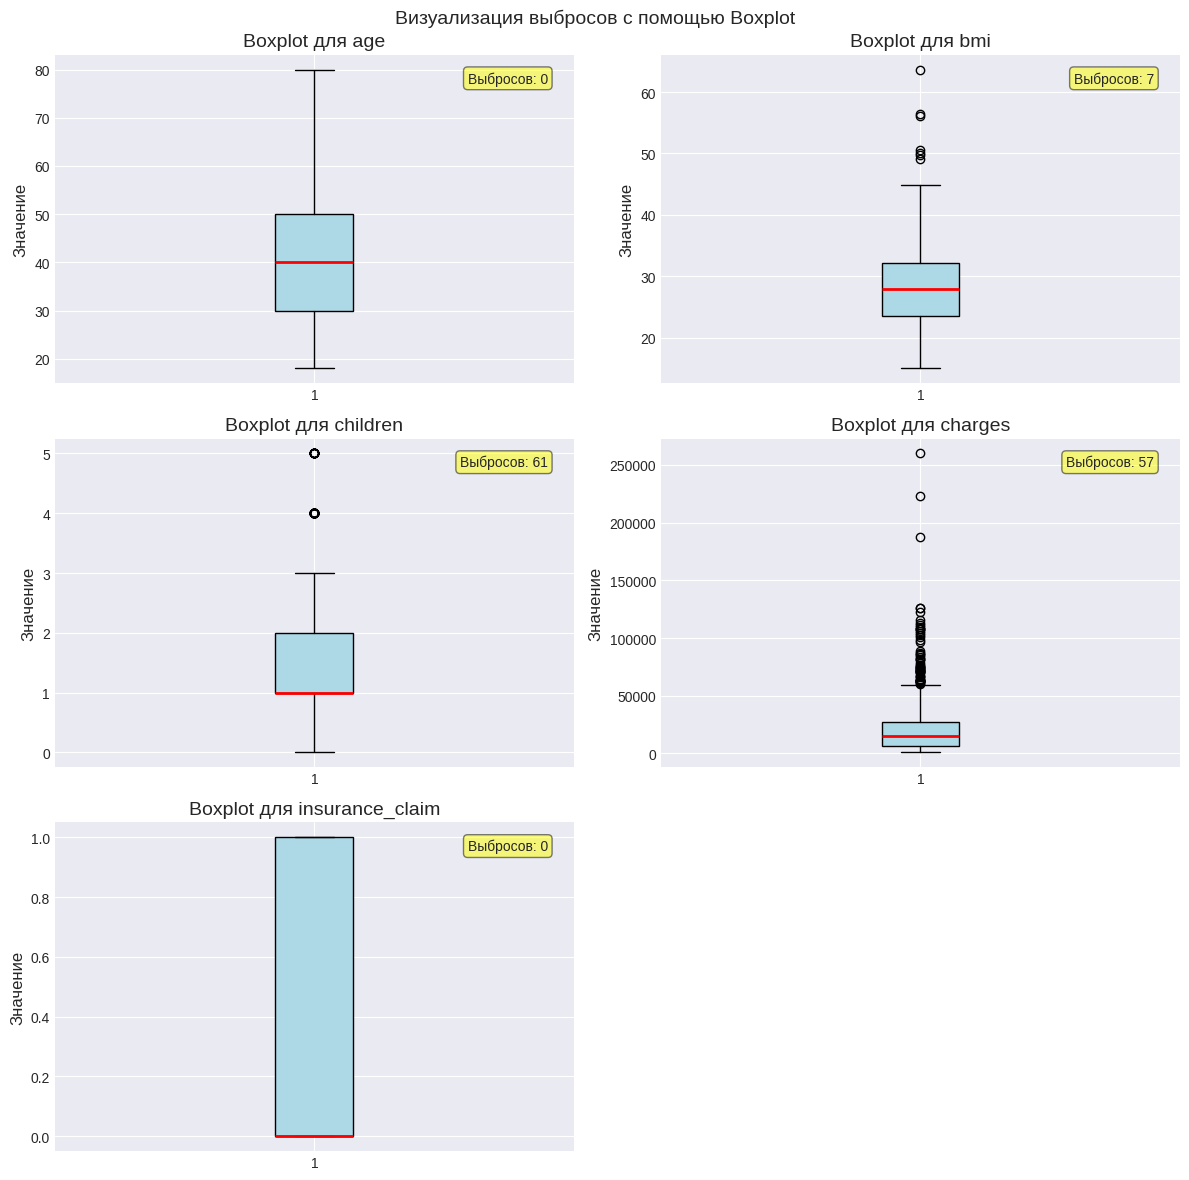


Обнаружение выбросов методом IQR:

age:
  Q1: 30.00, Q3: 50.00, IQR: 20.00
  Границы: [0.00, 80.00]
  Выбросов: 0 (0.0%)

bmi:
  Q1: 23.57, Q3: 32.17, IQR: 8.60
  Границы: [10.68, 45.07]
  Выбросов: 7 (0.7%)

children:
  Q1: 1.00, Q3: 2.00, IQR: 1.00
  Границы: [-0.50, 3.50]
  Выбросов: 61 (6.1%)

charges:
  Q1: 6317.17, Q3: 27662.99, IQR: 21345.82
  Границы: [-25701.56, 59681.72]
  Выбросов: 57 (5.8%)

insurance_claim:
  Q1: 0.00, Q3: 1.00, IQR: 1.00
  Границы: [-1.50, 2.50]
  Выбросов: 0 (0.0%)


In [ ]:
# Выбираем числовые признаки для анализа
# Создаем подходящий размер subplot
# Визуализация выбросов с помощью boxplot
# Применяем IQR для количественного анализа

age: 
q1: 30.0, q3: 50.0, iqr: 20.0
Границы: [0.00, 80.00]
Выбросов: 0 (0.0%)

children: 
q1: 1.0, q3: 2.0, iqr: 1.0
Границы: [-0.50, 3.50]
Выбросов: 61 (6.1%)

charges: 
q1: 6317.17, q3: 27662.99, iqr: 21345.82
Границы: [-25701.56, 59681.72]
Выбросов: 57 (5.7%)

bmi: 
q1: 23.57, q3: 32.17, iqr: 8.6
Границы: [10.68, 45.07]
Выбросов: 7 (0.7%)

insurance_claim: 
q1: 0.0, q3: 1.0, iqr: 1.0
Границы: [-1.50, 2.50]
Выбросов: 0 (0.0%)



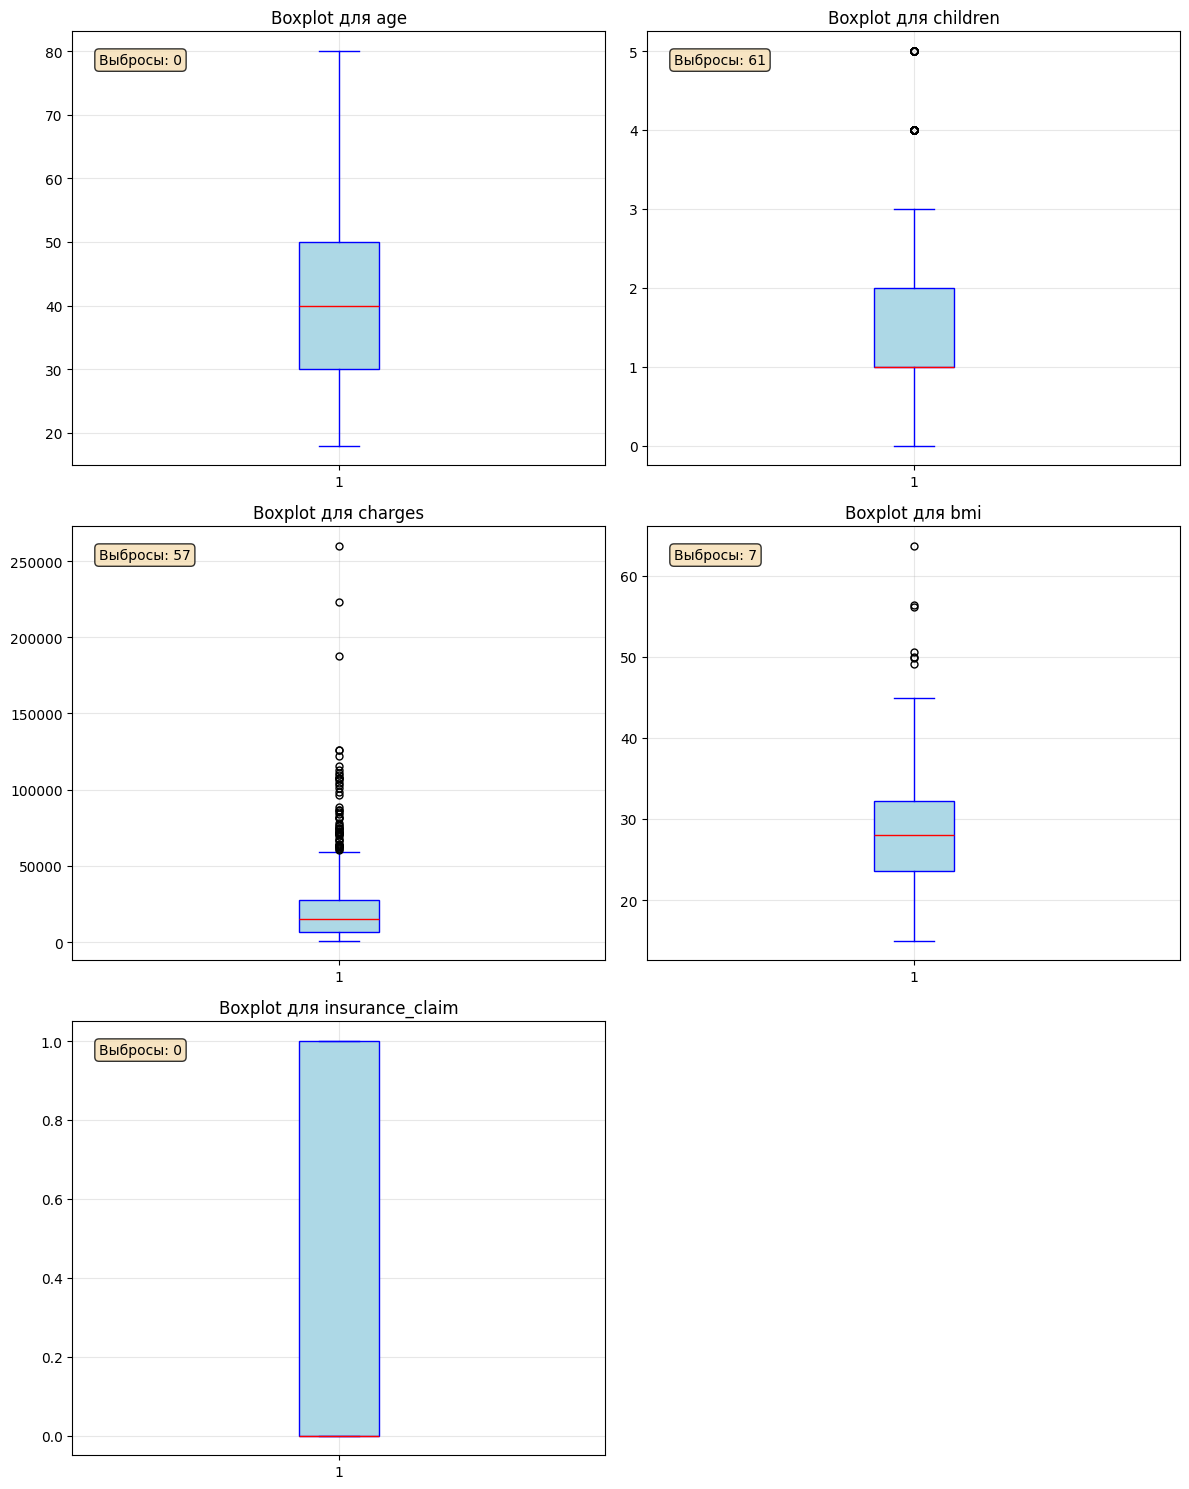

In [262]:
import math

features = ['age', 'children', 'charges', 'bmi', 'insurance_claim']

n_cols = 2
n_rows = math.ceil(len(features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
axes = axes.flatten()

for i, f in enumerate(features):
    q1, q3 = df_insurance[f].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((df_insurance[f] < lower_bound) | (df_insurance[f] > upper_bound)).sum()

    print(f"{f}: \nq1: {round(q1, 2)}, q3: {round(q3, 2)}, iqr: {round(iqr, 2)}\nГраницы: [{lower_bound:.2f}, {upper_bound:.2f}]\nВыбросов: {outlier_count} ({(outlier_count/10)}%)\n")

    ax = axes[i]  # используем ось из массива
    ax.boxplot(
        df_insurance[f].dropna(),
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', color='blue'),
        medianprops=dict(color='red'),
        whiskerprops=dict(color='blue'),
        capprops=dict(color='blue'),
        flierprops=dict(marker='o', color='red', markersize=5)
    )
    ax.set_title(f'Boxplot для {f}')
    ax.grid(True, alpha=0.3)

    # Вывод выбросов
    ax.text(
        0.05, 0.95, f'Выбросы: {outlier_count}',
        transform=ax.transAxes,
        ha='left', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    )

# Удаляем пустые оси, если число признаков нечётное
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 5. Анализ распределений и взаимосвязей

Задание 4.1: выполните визуализацию распределений для двух ключевых признаков: charges и bmi, а также постройте кореллограмму

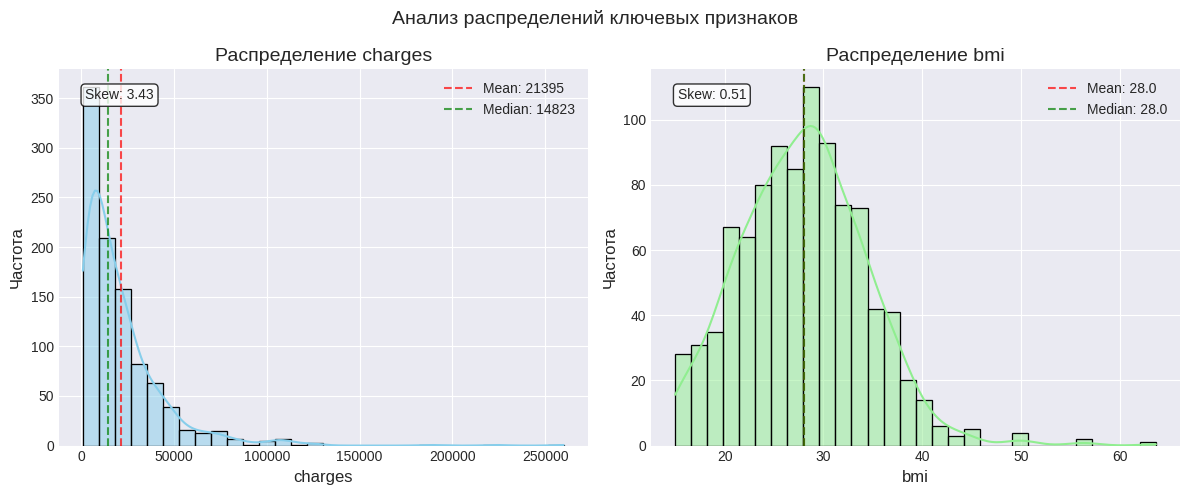

Корреляционная матрица (Пирсон):
                   age    bmi  children  charges  insurance_claim
age              1.000  0.037     0.014    0.006           -0.026
bmi              0.037  1.000     0.030    0.027           -0.032
children         0.014  0.030     1.000   -0.038           -0.029
charges          0.006  0.027    -0.038    1.000           -0.029
insurance_claim -0.026 -0.032    -0.029   -0.029            1.000


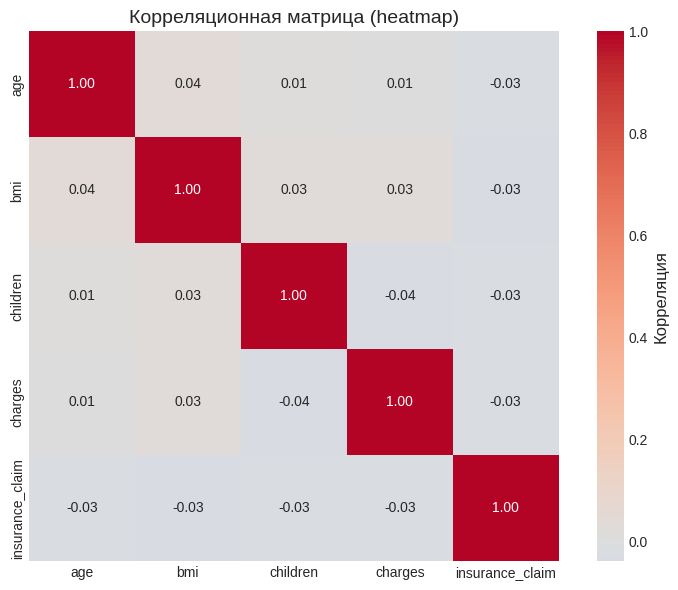

In [ ]:
# Визуализация распределений для двух ключевых признаков
# Гистограмма для charges
# Добавляем статистики для charges (mean, median, skew)
# Гистограмма для bmi
# Добавляем статистики для bmi (mean, median, skew)
# Расчет и вывод на экран корреляционной матрицы
# Коррелограмма (heatmap)


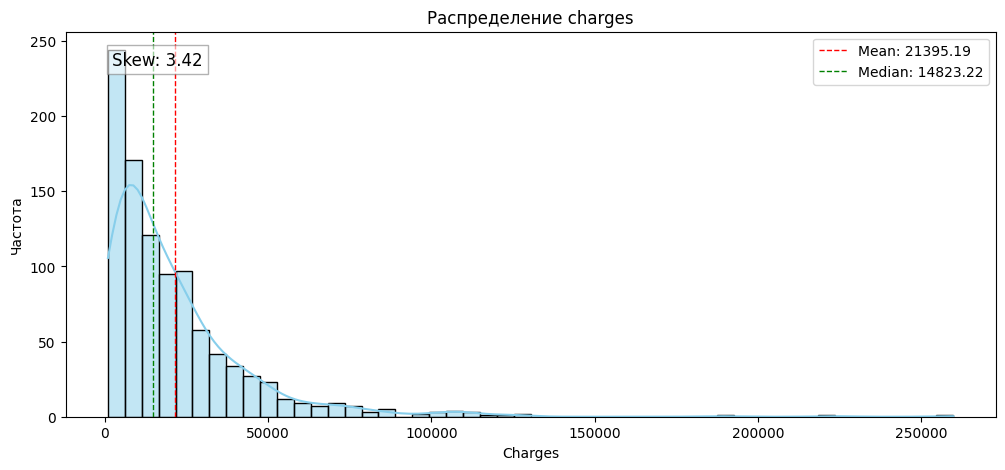

Charges: mean=21395.19, median=14823.22, skew=3.42


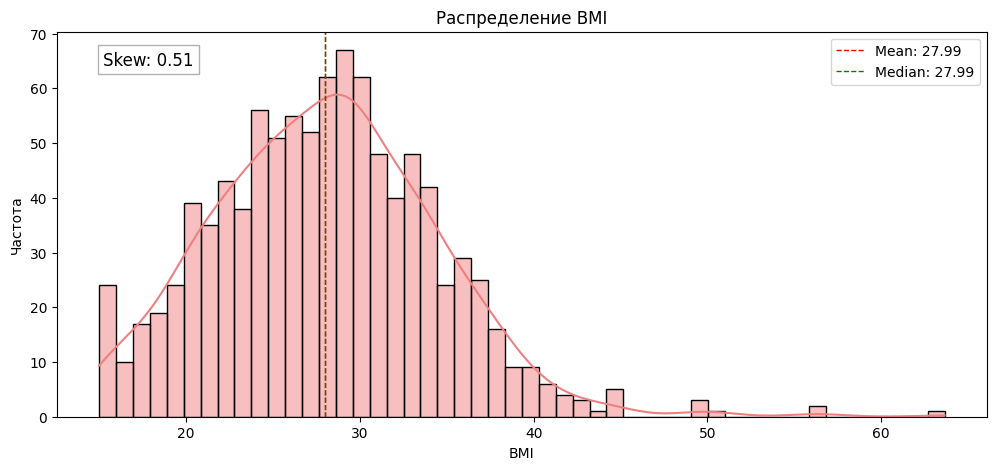

BMI: mean=27.99, median=27.99, skew=0.51

Корреляционная матрица:
                      age       bmi  children   charges  insurance_claim
age              1.000000  0.037241  0.013910  0.006119        -0.025864
bmi              0.037241  1.000000  0.030424  0.026661        -0.032390
children         0.013910  0.030424  1.000000 -0.038488        -0.029389
charges          0.006119  0.026661 -0.038488  1.000000        -0.029412
insurance_claim -0.025864 -0.032390 -0.029389 -0.029412         1.000000


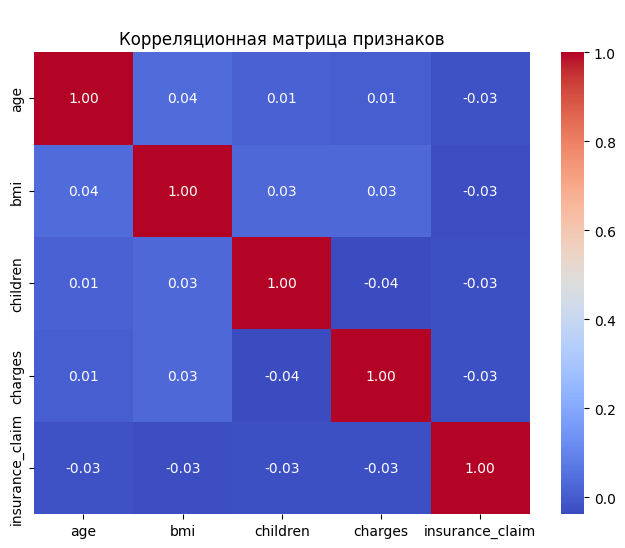

In [249]:
# Гистограмма для charges
plt.figure(figsize=(12, 5))
sns.histplot(df_insurance['charges'], bins=50, kde=True, color='skyblue')
plt.title('Распределение charges')
plt.xlabel('Charges')
plt.ylabel('Частота')

# Статистики для charges
mean_charges = df_insurance['charges'].mean()
median_charges = df_insurance['charges'].median()
skew_charges = skew(df_insurance['charges'].dropna())

plt.axvline(mean_charges, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_charges:.2f}')
plt.axvline(median_charges, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_charges:.2f}')
plt.text(0.05, 0.95, f"Skew: {skew_charges:.2f}",
         horizontalalignment='left',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))
plt.legend()
plt.show()

print(f"Charges: mean={mean_charges:.2f}, median={median_charges:.2f}, skew={skew_charges:.2f}")

# Гистограмма для bmi
plt.figure(figsize=(12, 5))
sns.histplot(df_insurance['bmi'].dropna(), bins=50, kde=True, color='lightcoral')
plt.title('Распределение BMI')
plt.xlabel('BMI')
plt.ylabel('Частота')

# Статистики для bmi
mean_bmi = df_insurance['bmi'].mean()
median_bmi = df_insurance['bmi'].median()
skew_bmi = skew(df_insurance['bmi'].dropna())

plt.axvline(mean_bmi, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_bmi:.2f}')
plt.axvline(median_bmi, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_bmi:.2f}')
plt.text(0.05, 0.95, f"Skew: {skew_bmi:.2f}",
         horizontalalignment='left',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))
plt.legend()
plt.show()

print(f"BMI: mean={mean_bmi:.2f}, median={median_bmi:.2f}, skew={skew_bmi:.2f}")

# Корреляционная матрица
corr_matrix = df_insurance[['age', 'bmi', 'children', 'charges', 'insurance_claim']].corr()
print("\nКорреляционная матрица:")
print(corr_matrix)

# Коррелограмма (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('\nКорреляционная матрица признаков')
plt.show()


Задание 4.2: ответить на вопросы

```
Вопрос 1: Какие выводы можно сделать о пропущенных данных?
A) Больше всего пропусков в признаке 'charges'
B) Пропуски случайно распределены по датасету
C) Пропуски в 'bmi' связаны с признаком 'smoker'
D) Все признаки имеют примерно одинаковый процент пропусков

Вопрос 2: Какой подход к обработке пропусков НАИБОЛЕЕ подходит для этого датасета?
A) Удалить все строки с пропусками
B) Удалить все колонки с пропусками
C) Заполнить пропуски медианными значениями
D) Использовать продвинутые методы импутации на основе других признаков

Вопрос 3: Что показывают boxplot для 'charges'?
A) Распределение нормальное, без выбросов
B) Много выбросов в верхней части (высокие значения)
C) Выбросы только в нижней части
D) Распределение симметричное

Вопрос 4: Какой признак имеет НАИБОЛЬШЕЕ влияние на целевую переменную 'insurance_claim'?
A) age (возраст)
B) bmi (индекс массы тела)
C) charges (стоимость страховки)
D) children (количество детей)

Вопрос 5: Какова природа корреляции между 'age' и 'charges'?
A) Отрицательная сильная корреляция
B) Положительная умеренная корреляция
C) Нет значимой корреляции
D) Нелинейная зависимость
```

C, A, B, B, C